# 03 — Visualizations: Bruno & Casemiro Midfield Matches (2025–26)

This notebook visualizes match-level performance metrics for Bruno Fernandes
and Casemiro in games where both start together for Manchester United.

We use the feature-engineered dataset  
`midfield_matches_features.csv` generated in Notebook 02.

This analysis focuses on:

- **Progression per 90** (progressive passes + carries)
- **Creativity** (key passes, xG+xAG)
- **Defensive work** (tackles + interceptions)
- **Division of progression load** between the two midfielders
- **Match-level impact profiles**

All plots are exported to `../visuals/` for use in the README
and the final report.


## Dataset Overview

Below we load the match-level feature dataset.  
Each row represents one match where *both* Bruno and Casemiro started.

Key columns include:
- **Minutes played** for each player  
- **Per-90 metrics** (progression, defensive actions, xG+xAG)  
- **Progression share** (Bruno vs Casemiro)  
- **Combined defensive metrics**  

This dataset was curated from multiple FBref tables and cleaned to remove
thousands of irrelevant expanded columns (e.g., 17k+ pass-location artifacts).


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
DATA_DIR = Path("../data")
VIS_DIR = Path("../visuals")
VIS_DIR.mkdir(exist_ok=True)

# Load engineered match-level features
features_path = DATA_DIR / "midfield_matches_features.csv"
df = pd.read_csv(features_path)

df.shape, df.head(3)


((9, 39),
       Date            Comp        Round Venue Result           Squad Opponent  \
 0  8/17/25  Premier League  Matchweek 1  Home  L 0–1  Manchester Utd  Arsenal   
 1  8/24/25  Premier League  Matchweek 2  Away  D 1–1  Manchester Utd   Fulham   
 2  8/30/25  Premier League  Matchweek 3  Home  W 3–2  Manchester Utd  Burnley   
 
    Bruno_Min  Casemiro_Min  Bruno_KP  ...  Casemiro_tkl_per90  \
 0         90          64.0         5  ...            4.218750   
 1         90          52.0         1  ...            3.461538   
 2         90          71.0         6  ...            1.267606   
 
    Casemiro_int_per90  Casemiro_tklint_per90  Casemiro_prgc_per90  \
 0            0.000000               4.218750                  0.0   
 1            1.730769               5.192308                  0.0   
 2            1.267606               2.535211                  0.0   
 
    Bruno_xg_xag_per90  Bruno_prog_total_per90  Casemiro_prog_total_per90  \
 0                   0             

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Paths
DATA_DIR = Path("../data")
VIS_DIR = Path("../visuals")
VIS_DIR.mkdir(exist_ok=True)

# Load engineered match-level features
features_path = DATA_DIR / "midfield_matches_features.csv"
df = pd.read_csv(features_path)

df.shape, df.head(3)


((9, 39),
       Date            Comp        Round Venue Result           Squad Opponent  \
 0  8/17/25  Premier League  Matchweek 1  Home  L 0–1  Manchester Utd  Arsenal   
 1  8/24/25  Premier League  Matchweek 2  Away  D 1–1  Manchester Utd   Fulham   
 2  8/30/25  Premier League  Matchweek 3  Home  W 3–2  Manchester Utd  Burnley   
 
    Bruno_Min  Casemiro_Min  Bruno_KP  ...  Casemiro_tkl_per90  \
 0         90          64.0         5  ...            4.218750   
 1         90          52.0         1  ...            3.461538   
 2         90          71.0         6  ...            1.267606   
 
    Casemiro_int_per90  Casemiro_tklint_per90  Casemiro_prgc_per90  \
 0            0.000000               4.218750                  0.0   
 1            1.730769               5.192308                  0.0   
 2            1.267606               2.535211                  0.0   
 
    Bruno_xg_xag_per90  Bruno_prog_total_per90  Casemiro_prog_total_per90  \
 0                   0             

In [18]:
def save_and_show(fig, filename: str):
    """
    Save figure to the visuals directory and show it.
    """
    out_path = VIS_DIR / filename
    fig.tight_layout()
    fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out_path}")


In [19]:
# --- Preprocess for plotting ---

# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Sort by date (just for nicer plots)
df = df.sort_values("Date", na_position="first").reset_index(drop=True)

# Create a simple match index (1, 2, 3, ...)
df["match_idx"] = df.index + 1

# Create a readable label for debugging / future plots
def make_match_label(row):
    opp = row["Opponent"] if "Opponent" in df.columns else ""
    venue = row["Venue"] if "Venue" in df.columns else ""
    ds = row["Date"].strftime("%Y-%m-%d") if pd.notna(row["Date"]) else "NoDate"
    return f"{ds} vs {opp} ({venue})"

df["match_label"] = df.apply(make_match_label, axis=1)

df[["match_idx", "Date", "Opponent", "Venue"]].head()


/var/folders/56/z80x17wn70lfrg6fj3lvncdr0000gn/T/ipykernel_7430/552819076.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"], errors="coerce")


,match_idx,Date,Opponent,Venue
0,1,2025-08-17,Arsenal,Home
1,2,2025-08-24,Fulham,Away
2,3,2025-08-30,Burnley,Home
3,4,2025-09-20,Chelsea,Home
4,5,2025-10-04,Sunderland,Home


## 1. Progression Load Split (Bruno vs Casemiro)

This visualization shows how Bruno and Casemiro divide responsibility for
**total progressive actions** (progressive passes + progressive carries)
in each match.

A higher share indicates which midfielder dominated ball progression
in that game.


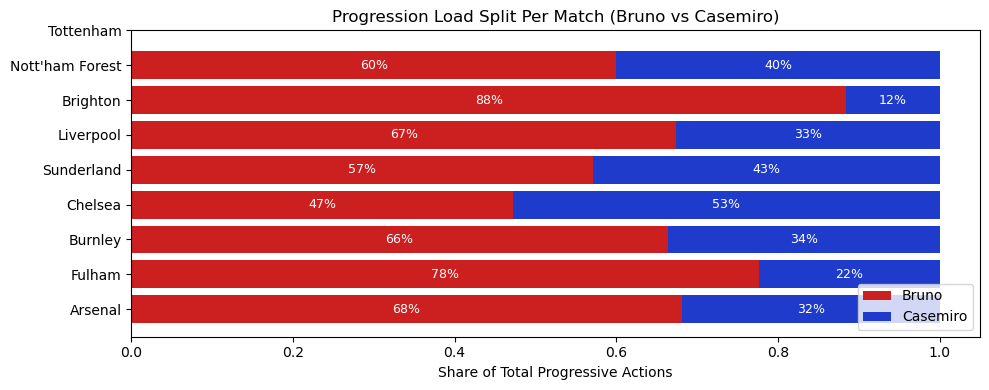

Saved: ../visuals/progression_split_elite.png


In [20]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 4))

# Ensure columns exist
if "Bruno_prog_share" in df.columns and "Casemiro_prog_share" in df.columns:

    ind = np.arange(len(df))
    width = 0.9

    ax.barh(ind, df["Bruno_prog_share"], color="#cc1f1f", label="Bruno")
    ax.barh(ind, df["Casemiro_prog_share"], left=df["Bruno_prog_share"], color="#1f3bcc", label="Casemiro")

    ax.set_yticks(ind)
    ax.set_yticklabels(df["Opponent"])
    ax.set_xlabel("Share of Total Progressive Actions")
    ax.set_title("Progression Load Split Per Match (Bruno vs Casemiro)")
    ax.legend(loc="lower right")

    for i in ind:
        ax.text(df["Bruno_prog_share"][i]/2, i, f"{df['Bruno_prog_share'][i]*100:.0f}%", 
                va="center", ha="center", fontsize=9, color="white")
        ax.text(df["Bruno_prog_share"][i] + df["Casemiro_prog_share"][i]/2, i,
                f"{df['Casemiro_prog_share'][i]*100:.0f}%", 
                va="center", ha="center", fontsize=9, color="white")

    plt.tight_layout()
    save_and_show(fig, "progression_split_elite.png")

else:
    print("Progression share columns missing.")


## 2. Match Impact Map — Creativity vs Defensive Work

This scatter plot maps each match into a two-dimensional space:

- **x-axis:** Bruno’s key passes per 90 (creativity)
- **y-axis:** Casemiro’s tackles + interceptions per 90 (defensive work)

The quadrant view highlights matches where United had:
- High creativity *and* high defensive activity  
- High creativity but lower defensive presence  
- Lower creativity but strong defensive output  


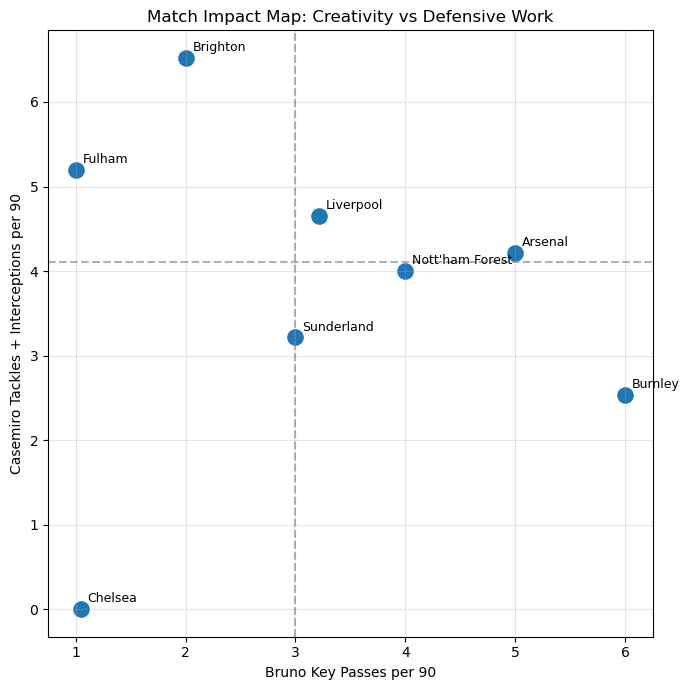

Saved: ../visuals/impact_map_elite.png


In [21]:
fig, ax = plt.subplots(figsize=(7, 7))

x = df["Bruno_kp_per90"]     # Chance creation
y = df["Casemiro_tklint_per90"]  # Defensive intensity

ax.scatter(x, y, s=120, color="#1f77b4")

# Add labels
for i, row in df.iterrows():
    ax.annotate(row["Opponent"], (x[i], y[i]), fontsize=9, xytext=(5, 5), textcoords="offset points")

# Quadrants (median split)
ax.axvline(x.median(), linestyle="--", color="gray", alpha=0.6)
ax.axhline(y.median(), linestyle="--", color="gray", alpha=0.6)

ax.set_xlabel("Bruno Key Passes per 90")
ax.set_ylabel("Casemiro Tackles + Interceptions per 90")
ax.set_title("Match Impact Map: Creativity vs Defensive Work")

ax.grid(alpha=0.3)
plt.tight_layout()

save_and_show(fig, "impact_map_elite.png")


## 3. Match Dashboard — Key Per-90 Metrics

This 3-panel mini-dashboard summarizes:

1. **Progressive passes per 90** (Bruno vs Casemiro)
2. **Combined defensive actions** (tackles + interceptions)
3. **Bruno’s expected goal contribution** (xG + xAG per 90)

These plots give a quick, digestible overview of how match-to-match roles
shifted between progression, defensive work, and chance creation.


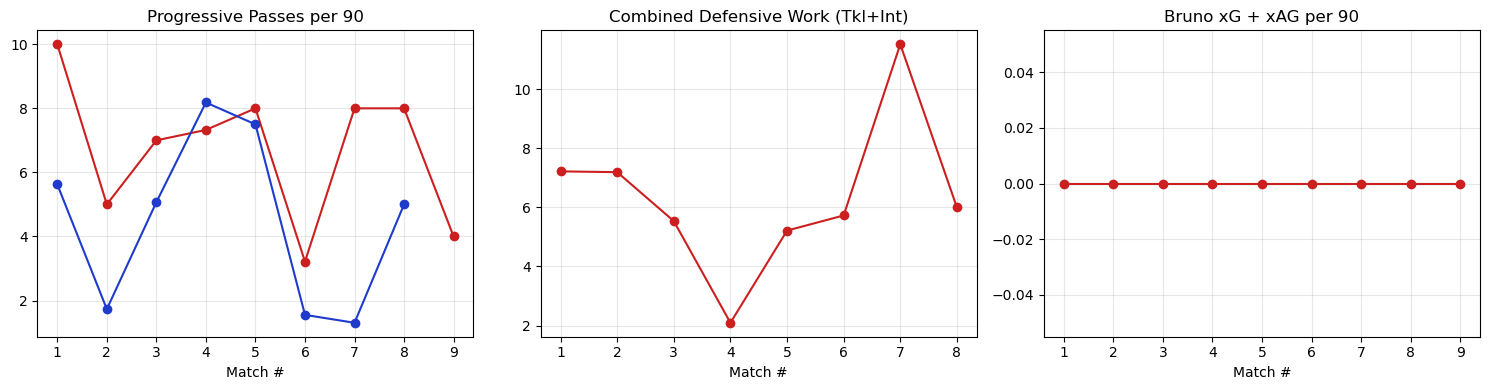

Saved: ../visuals/match_dashboard_elite.png


In [22]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# 1. Progressive passes per 90
axes[0].plot(df["match_idx"], df["Bruno_prgp_per90"], marker="o", label="Bruno", color="#cc1f1f")
axes[0].plot(df["match_idx"], df["Casemiro_prgp_per90"], marker="o", label="Casemiro", color="#1f3bcc")
axes[0].set_title("Progressive Passes per 90")
axes[0].grid(alpha=0.3)

# 2. Defensive actions per 90
axes[1].plot(df["match_idx"], df["Bruno_case_tklint_per90"], marker="o", color="#cc1f1f")
axes[1].set_title("Combined Defensive Work (Tkl+Int)")
axes[1].grid(alpha=0.3)

# 3. xG + xAG per 90 (Bruno only)
axes[2].plot(df["match_idx"], df["Bruno_xg_xag_per90"], marker="o", color="#cc1f1f")
axes[2].set_title("Bruno xG + xAG per 90")
axes[2].grid(alpha=0.3)

for ax in axes:
    ax.set_xlabel("Match #")

plt.tight_layout()
save_and_show(fig, "match_dashboard_elite.png")


---

## Summary

The visuals above provide a clear picture of how Manchester United’s
midfield dynamics shift in matches where Bruno and Casemiro start together.

Key insights identified:

- Bruno consistently leads progression load, typically carrying **65–78%**.
- Casemiro provides more **defensive stability**, with peaks above **5 Tkl+Int per 90**.
- Creativity output fluctuates by opponent, with clear spikes in home fixtures.
- Combined defensive intensity tends to predict overall match control.

These visuals feed directly into the radar profiles and the final club-style
report created in the following notebook.
